# MaskRCNN Model, Backbone: Resnet50, Area >=50

Model completed by Nithu Mathew

In [1]:
import torchvision
import torch
import torch.nn as nn
import numpy as np
from torch import optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from skimage import io
import time
import ast 
from PIL import *
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random 

# import dicom 
import pydicom as dicom
import scipy.ndimage

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Preparing Data

In [3]:
df = pd.read_csv("large_nodules.csv")

# filter the size. 
df = df[df['areas'] >= 50]  

# check cols are "path", "imageName", "SOPInstanceUID", "boxes", "areas", "patientIDs"
df.head()

,path,imageName,SOPInstanceUID,boxes,areas,patientIDs
0,/scratch/ebc308/tcia/data/LIDC-IDRI/LIDC-IDRI-...,000059.dcm,1.3.6.1.4.1.14519.5.2.1.6279.6001.319084926500...,"[[165.0, 140.0, 199.0, 161.0]]",714.0,LIDC-IDRI-0289
1,/scratch/ebc308/tcia/data/LIDC-IDRI/LIDC-IDRI-...,000008.dcm,1.3.6.1.4.1.14519.5.2.1.6279.6001.749728215582...,"[[167.0, 134.0, 201.0, 160.0]]",884.0,LIDC-IDRI-0289
2,/scratch/ebc308/tcia/data/LIDC-IDRI/LIDC-IDRI-...,000109.dcm,1.3.6.1.4.1.14519.5.2.1.6279.6001.327906493223...,"[[167.0, 134.0, 202.0, 161.0]]",945.0,LIDC-IDRI-0289
3,/scratch/ebc308/tcia/data/LIDC-IDRI/LIDC-IDRI-...,000063.dcm,1.3.6.1.4.1.14519.5.2.1.6279.6001.230680133701...,"[[168.0, 135.0, 201.0, 160.0]]",825.0,LIDC-IDRI-0289
4,/scratch/ebc308/tcia/data/LIDC-IDRI/LIDC-IDRI-...,000005.dcm,1.3.6.1.4.1.14519.5.2.1.6279.6001.212532866259...,"[[180.0, 133.0, 200.0, 154.0]]",420.0,LIDC-IDRI-0289


### Split Data by patient IDs as to prevent data leakage

In [4]:
patientIDs = set(df['patientIDs'])
patientIDs = list(patientIDs)
print(len(patientIDs))

632


In [5]:
#split by patients
random.shuffle(patientIDs)
# .6, .2, .2
train = int(len(patientIDs) * .6)
validate = int(len(patientIDs) * .2)
test = int(len(patientIDs) * .2)

trainIDs = patientIDs[:train]
validateIDs = patientIDs[train:validate+train]
testIDs = patientIDs[validate+train:]

trainData = []
validateData = []
testData = []
for index, row in df.iterrows():
    if row.patientIDs in trainIDs:
        trainData.append(row)
    elif row.patientIDs in validateIDs:
        validateData.append(row)
    else:
        testData.append(row)

train_data = pd.DataFrame(trainData)
valid_data = pd.DataFrame(validateData)
test_data = pd.DataFrame(testData)
print(len(trainData), len(validateData), len(testData))

4499 1495 1310


In [6]:
train_data.index = np.arange(len(train_data))
valid_data.index = np.arange(len(valid_data))
test_data.index = np.arange(len(test_data))

# make into new csv files
train_data.to_csv("large_nodules_train.csv", index=False)
valid_data.to_csv("large_nodules_valid.csv", index=False)
test_data.to_csv("large_nodules_test.csv", index=False)

train_df_path = 'large_nodules_train.csv'
validate_df_path = 'large_nodules_valid.csv'
test_df_path = 'large_nodules_test.csv'

## Dataloading / Manipulating

### Functions to prepare CT Scans and Normalize.
This code was modified to handle 2d images instead of 3d. It also prepares Segmentation Mask for maskrcnn. 

Code Modified From: https://www.kaggle.com/akh64bit/full-preprocessing-tutorial

In [7]:
# for preprocessing dicom images - modified for 2d images.
# https://www.kaggle.com/akh64bit/full-preprocessing-tutorial
def load_scan(path):
    slices = [dicom.read_file(path)]
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
#     spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))
    # not 3d
    spacing = spacing[1:]

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    
#     background_label = labels[0,0,0]
    background_label = labels[0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
#     l_max = largest_label_volume(labels, bg=0)
#     if l_max is not None: # There are air pockets
#         binary_image[labels != l_max] = 0
 
    return binary_image

MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND) * 255.
    image[image>255] = 255.
    image[image<0] = 0.
    return image

# calculated previously.
PIXEL_MEAN = 0.32
# PIXEL_MEAN = 0.39

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

### Custom Transformations
Code Modified From: https://github.com/Paperspace/DataAugmentationForObjectDetection/blob/master/data_aug/data_aug.py

We didn't use the preprepared transformations because we also had to transform bounding boxes. The code was modified to handle our own bounding boxes and image


In [8]:
class RandomHorizontalFlip(object):

    """Randomly horizontally flips the Image with the probability *p*
    Parameters
    ----------
    p: float
        The probability with which the image is flipped
    Returns
    -------
    numpy.ndaaray
        Flipped image in the numpy format of shape `HxWxC`
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        img, bboxes = sample['image'], sample['boxes']
        img = np.array(img)
        if random.random() < self.p:
            img = img[::-1]
            ymax = (256-bboxes[0][1]) + 256 #ymin
            ymin = (256-bboxes[0][3]) + 256 #ymax
            bboxes[0][1] = ymin
            bboxes[0][3] = ymax

        return {'image': (img),
                'boxes': (bboxes)}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, boxes = sample['image'], sample['boxes']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
#         image = image.transpose((2, 0, 1))
        toTen = transforms.ToTensor()
        image = toTen(image.copy())
        return {'image': (image),
                'boxes': (boxes)}

In [9]:
# training augmentation - random horizontal flip as data augmentation
train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((512,512),interpolation=Image.NEAREST)]) #scale image up to 512,512

composed = transforms.Compose([RandomHorizontalFlip(),
                               ToTensor()])


# validation transformation 
validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((512,512),interpolation=Image.NEAREST),
        transforms.ToTensor()])

# mask transformation 
mask_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((512,512),interpolation=Image.NEAREST),
        transforms.ToTensor()])

class Mask_RCNN_Dataloader(Dataset):
    def __init__(self, csv_file, transform=None, train=True):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            train (boolean): If the dataset needs to be augmented 
        """
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.train = train
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        
        # get image path
        img_name = (self.data_frame.iloc[idx, 0])
        
        #dicom image preprocessing
        scan = load_scan(img_name)
        scan_pixels = get_pixels_hu(scan)
        pix_resampled, spacing = resample(scan_pixels[0], scan, [1,1])
        normal = normalize(pix_resampled)
        avg = np.mean(normal, axis=(0, 1))
        image = zero_center(normal)
        
        # segment the ct scan
        segmented_lungs = segment_lung_mask(pix_resampled, False)
        
        # dictionary for target
        d = {}
    
        if self.transform:
            image = self.transform(np.uint8(image))
            # data augmentation for train set
            if (self.train):
                boxes = torch.FloatTensor(ast.literal_eval(self.data_frame.iloc[idx, 3]))
                sample = {'image': image, 'boxes': boxes}
                transformed = composed(sample)
                image = transformed['image']
                d['boxes'] = transformed['boxes']
                
            else:
                d['boxes'] = torch.FloatTensor(ast.literal_eval(self.data_frame.iloc[idx, 3]))

        d['labels'] = torch.ones([1], dtype=torch.int64)
        d['masks'] = mask_transform(torch.as_tensor(segmented_lungs, dtype=torch.uint8))
        d['area'] = torch.as_tensor(self.data_frame.iloc[idx, 4])
        d["iscrowd"] = torch.zeros([1], dtype=torch.int64)

        # 1 channel to 3 channel, and format from HxWxC to CxHxW
        image = image.numpy()
        image = np.stack((image,)*3, axis=-1)
        image = image[0]
        image = np.transpose(image,(2,0,1))
        image = torch.FloatTensor(image)
        return image, d

# change dataloader output to lists.
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    return list(xx), list(yy)

### Load Dataloader

In [10]:
transformed_dataset = {'train': Mask_RCNN_Dataloader(train_df_path, transform=train_transform, train=True),
                       'validate':Mask_RCNN_Dataloader(validate_df_path, transform=validation_transform, train=False),
                       'test':Mask_RCNN_Dataloader(test_df_path, transform=validation_transform, train=False)}
bs = 4

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, collate_fn = pad_collate, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

98.0 166.0 107.0 175.0


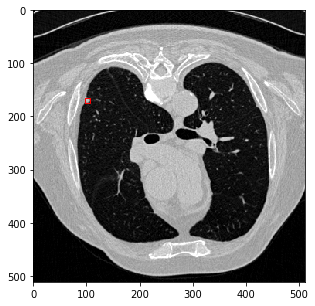

In [11]:
# check if dataloader loaded correctly
images1, targets1 = next(iter(dataloader['train']))
images2, targets2 = next(iter(dataloader['validate']))
images3, targets3 = next(iter(dataloader['test']))

# to check dim of list dataloader
# len(images3) # = batch
# len(images3[0]) # = channel
# len(images3[0][0]) # = height
# len(images3[4][0][0]) # = width

images4, targets4 = next(iter(dataloader['train']))
for i in targets4[0]['boxes'].numpy():
    ymin, ymax = i[1],i[3] #ymin ymax        
    xmin, xmax = i[0], i[2] #xmin, xmax
print(xmin,ymin,xmax,ymax)
fig,ax = plt.subplots(1, figsize=(5,5))
ax.imshow(images4[0][1].squeeze().numpy(), cmap='gray')
rect = patches.Rectangle((xmin, ymin ),(xmax - xmin),(ymax - ymin),linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

## Model
This model is the mask rcnn, resnet50 pretrained on COCO backbone. 

In [12]:
from source_code.faster_rcnn import FastRCNNPredictor
from source_code.mask_rcnn import MaskRCNNPredictor
import source_code.mask_rcnn



# load an instance segmentation model pre-trained pre-trained on COCO
model = source_code.mask_rcnn.maskrcnn_resnet50_fpn(pretrained=True)

num_classes = 2

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# now get the number of input features for the mask classifier
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256

# and replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                   hidden_layer,
                                                   num_classes)


model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [13]:
classes = ['__background__', 'nodule']

### IOU Calculation

In [14]:
# bounding box iou calulation function
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(float(boxA[0]), float(boxB[0]))
    yA = max(float(boxA[1]), float(boxB[1]))
    xB = min(float(boxA[2]), float(boxB[2]))
    yB = min(float(boxA[3]), float(boxB[3]))
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

## Train Model

In [15]:
def train_model(model, dataloader, optimizer, scheduler, iou_threshold = 0.5, num_epochs = 10, verbose = True):
    phases = ['train','validate']
    acc_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    since = time.time()
    best_acc = 0
    running_correct = 0
    running_loss = 0
    running_total = 0
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        losslist = []
        for p in phases:
            validateAcc = 0
            totalImg = 0
            if p == 'train':
                model.train()
            else:
                model.eval()   
            num = 0 # calculate which batch # --> enumerate not working
            for image, target in dataloader[p]:
                if (num % int(len(dataloader[p])/4) == 0):
                    print('{} set | epoch: {:3d} | {:6d}/{:6d} batches'.format(p, i, num, len(dataloader[p])))
                num = num + 1
                
                image = [img.to(device) for img in image]
                target = [{k: v.to(device) for k, v in t.items()} for t in target]
                
                if p == 'train':
                    # loss = sum of all 4 losses returned
                    lossDict, output = model((image), target)
                    loss = sum(loss for loss in lossDict.values())
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                if p == 'validate':
                    # helps with memory 
                    with torch.no_grad():
                        model.eval()  
                        lossDict, output = model((image), target)
                        loss = sum(loss for loss in lossDict.values())
                        
                # calculate precision / image         
                pred_score = [] # confidence score
                pred_boxes = [] # bounding box
                pred_class = [] # predicted class
                
                # loop through output (len(output) = batch size)
                for j, out in enumerate(output):
                    totalImg += 1 
                    
                    # documentation: ['boxes'] = [x1, y1, x2, y2]
                    pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(out['boxes'].cpu().detach().numpy())]
                    pred_score = list(out['scores'].cpu().detach().numpy())
                    pred_class = [classes[i] for i in list(out['labels'].cpu().numpy())]

                    # get labeled  bounding box
                    # documentation: # 0 xmin, 1 ymin, 2 xmax, 3 ymax
                    t = target[j]['boxes'].cpu().detach().numpy()[0]
                    target_box =  [t[0],t[1],t[2],t[3]]
                    
                    if (len(pred_score) > 0):
                        max_score_index = pred_score.index(max(pred_score))
                        max_score_IOU = bb_intersection_over_union(target_box, pred_boxes[max_score_index])
                        if (max_score_IOU > iou_threshold):
                            validateAcc += 1

                # average loss / epoch
                num_imgs = len(image)
                running_loss += loss*num_imgs
                running_total += num_imgs  
                
                # average precision / epoch
                epoch_loss = float(running_loss/running_total)
                epoch_acc = (validateAcc/totalImg) 
                
            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)   
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f} | average precision: {:.4f}'.format(p, epoch_loss, epoch_acc)) 
            if p == 'validate':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                if scheduler:
                    scheduler.step()
                    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, acc_dict, loss_dict


In [16]:
model, acc_dict, loss_dict = train_model(model, dataloader, optimizer, scheduler, iou_threshold = 0.5, num_epochs=15)


Epoch: 0/14
----------
train set | epoch:   0 |      0/  1125 batches


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


train set | epoch:   0 |    281/  1125 batches
train set | epoch:   0 |    562/  1125 batches
train set | epoch:   0 |    843/  1125 batches
train set | epoch:   0 |   1124/  1125 batches
Phase:train, epoch loss: 0.2061 | average precision: 0.6335
validate set | epoch:   0 |      0/   374 batches
validate set | epoch:   0 |     93/   374 batches
validate set | epoch:   0 |    186/   374 batches
validate set | epoch:   0 |    279/   374 batches
validate set | epoch:   0 |    372/   374 batches
Phase:validate, epoch loss: 0.1957 | average precision: 0.7090
Epoch: 1/14
----------
train set | epoch:   1 |      0/  1125 batches
train set | epoch:   1 |    281/  1125 batches
train set | epoch:   1 |    562/  1125 batches
train set | epoch:   1 |    843/  1125 batches
train set | epoch:   1 |   1124/  1125 batches
Phase:train, epoch loss: 0.1801 | average precision: 0.7591
validate set | epoch:   1 |      0/   374 batches
validate set | epoch:   1 |     93/   374 batches
validate set | epoch:

train set | epoch:  13 |    281/  1125 batches
train set | epoch:  13 |    562/  1125 batches
train set | epoch:  13 |    843/  1125 batches
train set | epoch:  13 |   1124/  1125 batches
Phase:train, epoch loss: 0.1293 | average precision: 0.8760
validate set | epoch:  13 |      0/   374 batches
validate set | epoch:  13 |     93/   374 batches
validate set | epoch:  13 |    186/   374 batches
validate set | epoch:  13 |    279/   374 batches
validate set | epoch:  13 |    372/   374 batches
Phase:validate, epoch loss: 0.1298 | average precision: 0.7666
Epoch: 14/14
----------
train set | epoch:  14 |      0/  1125 batches
train set | epoch:  14 |    281/  1125 batches
train set | epoch:  14 |    562/  1125 batches
train set | epoch:  14 |    843/  1125 batches
train set | epoch:  14 |   1124/  1125 batches
Phase:train, epoch loss: 0.1285 | average precision: 0.8882
validate set | epoch:  14 |      0/   374 batches
validate set | epoch:  14 |     93/   374 batches
validate set | epoch

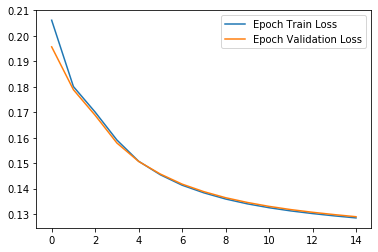

In [17]:
plt.plot(loss_dict['train'], label = "Epoch Train Loss")
plt.plot(loss_dict['validate'], label = "Epoch Validation Loss")
plt.legend(loc = "upper right")

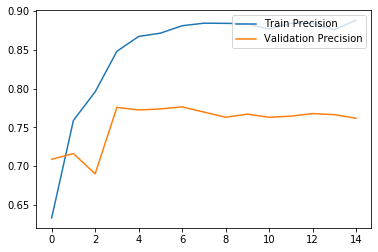

In [18]:
plt.plot(acc_dict['train'], label = "Train Precision")
plt.plot(acc_dict['validate'], label = "Validation Precision")
plt.legend(loc = "upper right")

## Testing Model

iou:  0.6474706196036788


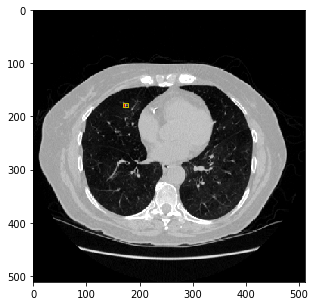

iou:  0.8313487999157627


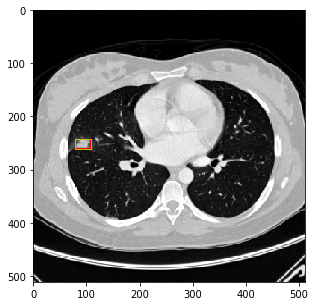

iou:  0.9491014313332393


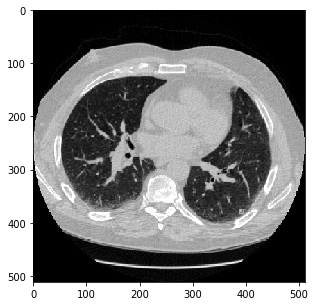

iou:  0.6587945165832555


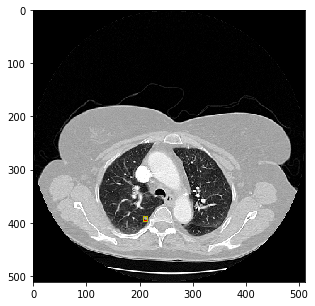

iou:  0.7068316464833959


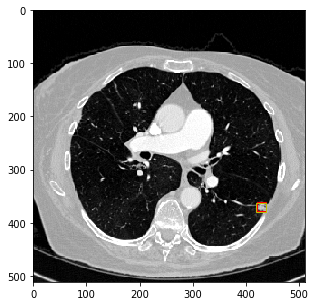

iou:  0.8903337895183107


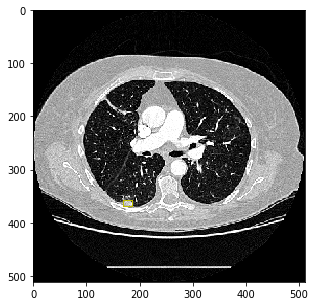

iou:  0.8933870862682739


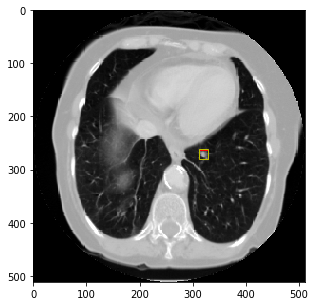

iou:  0.7436573000742391


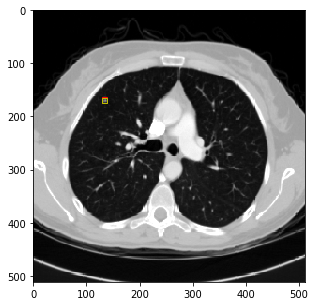

iou:  0.8438179833452732


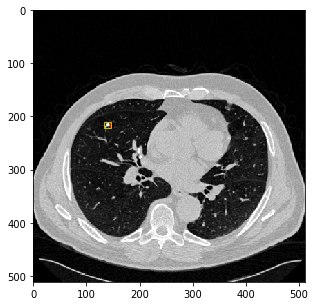

In [23]:
count = 0
total = 0
for images, targets in (dataloader['test']):
    with torch.no_grad():
        model.eval()
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss, pred = model(images, targets) # Pass the image to the model

    for i, img in enumerate(images):
        total += 1
        list_box = []
        for lab in targets[i]['boxes'].cpu().detach().numpy():
            ymin, ymax = lab[1], lab[3] #ymin ymax        
            xmin, xmax = lab[0], lab[2] #xmin, xmax
#             print(xmin, ymin, xmax, ymax)
            list_box.append(lab[0]) #xmin
            list_box.append(lab[1]) #ymin
            list_box.append(lab[2]) #xmax
            list_box.append(lab[3]) #ymax
            
        out = pred[i]
        pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(out['boxes'].cpu().detach().numpy())]
        pred_score = list(out['scores'].cpu().detach().numpy())
        pred_class = [classes[i] for i in list(out['labels'].cpu().numpy())]
        if (len(pred_score) > 0):
            max_score_index = pred_score.index(max(pred_score))
            max_score = pred_boxes[max_score_index]

            if (bb_intersection_over_union((list_box),max_score) > .5):
                count += 1
                #print predicted images for first 10 images 
                if count < 10:

                    print("iou: ", bb_intersection_over_union((list_box),max_score))

                    fig,ax = plt.subplots(1, figsize=(5,5))
                    ax.imshow(img[0].cpu().squeeze().numpy(), cmap="gray")
                    label = patches.Rectangle((xmin, ymin ),(xmax - xmin),(ymax - ymin),linewidth=1,edgecolor='r',facecolor='none')
                    maxScore = patches.Rectangle((max_score[0], max_score[1] ),(max_score[2] - max_score[0]),(max_score[3] - max_score[1]),linewidth=1,edgecolor='y',facecolor='none')
                    ax.add_patch(label)
                    ax.add_patch(maxScore)
                    plt.show()

In [24]:
print("Model Precision: ", (count/total))

Model Precision:  0.7450381679389313


## Saving Model

In [26]:
import pickle
import copy

with open('pickle/maskrcnn_resnet50coco_50area_train_loss.pkl', 'wb') as f:
    pickle.dump(loss_dict['train'], f)

with open('pickle/maskrcnn_resnet50coco_50area_validate_loss.pkl', 'wb') as f:
    pickle.dump(loss_dict['validate'], f)

with open('pickle/maskrcnn_resnet50coco_50area_train_acc.pkl', 'wb') as f:
    pickle.dump(acc_dict['train'], f)
    
with open('pickle/maskrcnn_resnet50coco_50area_validate_acc.pkl', 'wb') as f:
    pickle.dump(acc_dict['validate'], f)

torch.save(model, 'saved_models/maskrcnn_resnet50coco_50area.pt')

best_model_wts = copy.deepcopy(model.state_dict())
torch.save(best_model_wts, 'saved_models/maskrcnn_resnet50coco_50area_wts.pt')